# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import os
import numpy as np
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

train_dir = 'landmark_images/train/'
test_dir = 'landmark_images/test/'

# Resize the images to 224x224, convert them to tensors, and normalize them
# Normalization values taken from Imagenet results
train_data_transforms = transforms.Compose([transforms.Resize((256, 256)),
                                      transforms.CenterCrop(224),
                                      transforms.ColorJitter(brightness=0.5),
                                      transforms.RandomHorizontalFlip(), # randomly flip
                                      transforms.RandomRotation(20), # Randomly rotate
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Only resize and normalize for test data
test_data_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 32
num_workers = 0

# percentage of training set to use as validation
valid_size = 0.2

# Get the training, testing, and validation datasets
train_data = datasets.ImageFolder(train_dir, transform=train_data_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_data_transforms)
valid_data = datasets.ImageFolder(train_dir, transform=test_data_transforms)

# print out some data stats
print('Num training images: {} with {}% used for validation'.format(len(train_data), valid_size*100))
print('Num test images: ', len(test_data))

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=True)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


Num training images: 4996 with 20.0% used for validation
Num test images:  1250


In [2]:
import torch

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
1. The code uses the Resize and CenterCrop functions in the torchvision transforms library to crop the images down to 224x224. This size was chosen because it is a common input size for many classifier networks. One of the most popular classification image datasets, ImageNet, uses the 224x224 size so any pretrained network that was trained on ImageNet likely used that size. 
2. The training images were flipped, rotated, had their brightness fluctuaded and normalized during the augmentation step. This was done to help account for pictures being taken with a tilted camera, different side, or a strange angle. The testing and validation datasets received no augmentation other than resizing to the networks input size and normalization.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

['00.Haleakala_National_Park', '01.Mount_Rainier_National_Park', '02.Ljubljana_Castle', '03.Dead_Sea', '04.Wroclaws_Dwarves', '05.London_Olympic_Stadium', '06.Niagara_Falls', '07.Stonehenge', '08.Grand_Canyon', '09.Golden_Gate_Bridge', '10.Edinburgh_Castle', '11.Mount_Rushmore_National_Memorial', '12.Kantanagar_Temple', '13.Yellowstone_National_Park', '14.Terminal_Tower', '15.Central_Park', '16.Eiffel_Tower', '17.Changdeokgung', '18.Delicate_Arch', '19.Vienna_City_Hall', '20.Matterhorn', '21.Taj_Mahal', '22.Moscow_Raceway', '23.Externsteine', '24.Soreq_Cave', '25.Banff_National_Park', '26.Pont_du_Gard', '27.Seattle_Japanese_Garden', '28.Sydney_Harbour_Bridge', '29.Petronas_Towers', '30.Brooklyn_Bridge', '31.Washington_Monument', '32.Hanging_Temple', '33.Sydney_Opera_House', '34.Great_Barrier_Reef', '35.Monumento_a_la_Revolucion', '36.Badlands_National_Park', '37.Atomium', '38.Forth_Bridge', '39.Gateway_of_India', '40.Stockholm_City_Hall', '41.Machu_Picchu', '42.Death_Valley_National_Pa

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


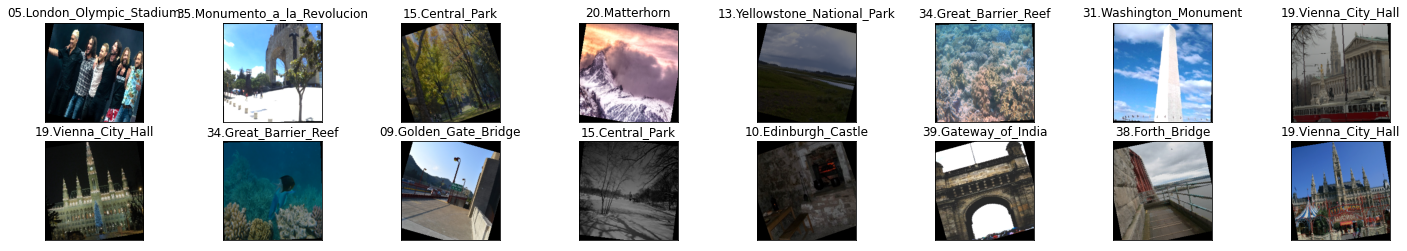

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader
# helper function to un-normalize and display an image
def imshow(img):
    # Define the unnormalization transform to unnormalize our images for display
    mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
    std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
    unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
    
    # Apply the transform and show the image
    img = unnormalize(img)
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
# Get a list of class names that we can easily index
classes = train_data.classes

print(classes)

dataiter = iter(train_loader)

# Grab a single batch of data
images, labels = dataiter.next()


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
num_to_show = int(batch_size/2)
for idx in np.arange(num_to_show):
    ax = fig.add_subplot(2, int(num_to_show/2), idx+1, xticks=[], yticks=[])
    
    # Use our custom imshow function to display the image
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])


### Initialize use_cuda variable

In [4]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [5]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    
    return optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [6]:
# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        # Convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.batchNormConv1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.batchNormConv2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.batchNormConv3 = nn.BatchNorm2d(256)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        num_pool = 3
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * int((224/(2**num_pool))**2), 256) # TODO: Replace 224 with a variable for image size
        self.batchNormFC1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.batchNormFC2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, len(classes))
        
        # Dropout
        self.dropout = nn.Dropout(0.2)      
        
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.batchNormConv1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.batchNormConv2(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.batchNormConv3(self.conv3(x))))
        x = self.dropout(x)
        
#         x = nn.Flatten(x)
        x = x.view(x.size(0), -1) # Flatten wasn't available so this is basically the same thing
        
        x = F.relu(self.batchNormFC1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.batchNormFC2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
    
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    print("GPU available, training on GPU")
else:
    print("No GPU available, training on CPU")

GPU available, training on GPU


__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
The CNN architecture was heavily based off of ones that were used in previous lessons. Convolutional layers of increasing depth are used for feature extraction while pooling layers are used to downsample the resultant images. The convolutional layers were made quite deep due to the complex nature of the images that needed to be classifier. I believed there would be many unique idnentifying features across the various images that would need to be learned by the kernels in the convolutional layers. The fully connected layers serve as the classification head of the network. This was based off some of the VGG networks that I was introduced to earlier in the NanoDegree. A replacement for a flattening layer was used to vectrorize the output of the feature extracting convolutional layers so it could be fed into the fully connected layers of the classification head. Batch normalization layers were also used after every convolutional and fully connected layer at the recommendation of my previous reviewer. I believe this in conjunction with my updated image augmentation techniques helped increase my testing accuracy from 24% to 40%. The batch normalization layers were also used in conjection with the dropout layers in order to prevent the network from overfitting. 

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

                
            # Zero out the optimizer
            optimizer.zero_grad()
            
            # Pass the data through the model
            output = model(data)
            
            # Compute the loss based on the output and target
            loss = criterion(output, target)
            
            # Backpropagate the loss through the model
            loss.backward()
            
            # Perform a single optimization step
            optimizer.step()
            
            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
         

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)

        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            
            # Save the model
            torch.save(model.state_dict(), save_path)
            # Update best loss
            valid_loss_min = valid_loss
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [21]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    # for every Linear layer in a model
    # m.weight.data shoud be taken from a normal distribution
    # m.bias.data should be 0
    if classname.find("Linear") != -1:
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)
    
    

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 0.000774 	Validation Loss: 0.747525
Validation loss decreased (inf --> 0.747525).  Saving model ...
Epoch: 2 	Training Loss: 0.000709 	Validation Loss: 0.720305
Validation loss decreased (0.747525 --> 0.720305).  Saving model ...
Epoch: 3 	Training Loss: 0.000674 	Validation Loss: 0.710834
Validation loss decreased (0.720305 --> 0.710834).  Saving model ...
Epoch: 4 	Training Loss: 0.000642 	Validation Loss: 0.699896
Validation loss decreased (0.710834 --> 0.699896).  Saving model ...
Epoch: 5 	Training Loss: 0.000626 	Validation Loss: 0.681809
Validation loss decreased (0.699896 --> 0.681809).  Saving model ...
Epoch: 6 	Training Loss: 0.000604 	Validation Loss: 0.668766
Validation loss decreased (0.681809 --> 0.668766).  Saving model ...
Epoch: 7 	Training Loss: 0.000585 	Validation Loss: 0.673778
Epoch: 8 	Training Loss: 0.000569 	Validation Loss: 0.706682
Epoch: 9 	Training Loss: 0.000557 	Validation Loss: 0.676618
Epoch: 10 	Training Loss: 0.000543 	Valida

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [8]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
from workspace_utils import active_session

num_epochs = 40

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)


# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 0.000761 	Validation Loss: 0.750464
Validation loss decreased (inf --> 0.750464).  Saving model ...
Epoch: 2 	Training Loss: 0.000708 	Validation Loss: 0.736626
Validation loss decreased (0.750464 --> 0.736626).  Saving model ...
Epoch: 3 	Training Loss: 0.000676 	Validation Loss: 0.702525
Validation loss decreased (0.736626 --> 0.702525).  Saving model ...
Epoch: 4 	Training Loss: 0.000649 	Validation Loss: 0.711260
Epoch: 5 	Training Loss: 0.000625 	Validation Loss: 0.704651
Epoch: 6 	Training Loss: 0.000603 	Validation Loss: 0.686449
Validation loss decreased (0.702525 --> 0.686449).  Saving model ...
Epoch: 7 	Training Loss: 0.000589 	Validation Loss: 0.700746
Epoch: 8 	Training Loss: 0.000571 	Validation Loss: 0.682736
Validation loss decreased (0.686449 --> 0.682736).  Saving model ...
Epoch: 9 	Training Loss: 0.000551 	Validation Loss: 0.654673
Validation loss decreased (0.682736 --> 0.654673).  Saving model ...
Epoch: 10 	Training Loss: 0.000536 	Valida

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [9]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [10]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.390369


Test Accuracy: 40% (508/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [11]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

train_dir = 'landmark_images/train/'
test_dir = 'landmark_images/test/'

# Resize the images to 224x224, convert them to tensors, and normalize them
# Normalization values taken from Imagenet results
train_data_transforms = transforms.Compose([transforms.Resize((256, 256)),
                                      transforms.CenterCrop(224),
                                      transforms.ColorJitter(brightness=0.5),
                                      transforms.RandomHorizontalFlip(), # randomly flip
                                      transforms.RandomRotation(20), # Randomly rotate
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Only resize and normalize for test data
test_data_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 32
num_workers = 0

# percentage of training set to use as validation
valid_size = 0.2

# Get the training, testing, and validation datasets
train_data = datasets.ImageFolder(train_dir, transform=train_data_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_data_transforms)
valid_data = datasets.ImageFolder(train_dir, transform=test_data_transforms)

# print out some data stats
print('Num training images: {} with {}% used for validation'.format(len(train_data), valid_size*100))
print('Num test images: ', len(test_data))

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=True)

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}



Num training images: 4996 with 20.0% used for validation
Num test images:  1250


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [12]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    
    # Only optimize the classifier portion of the model
    return optim.SGD(model.classifier.parameters(), lr = 0.01, momentum = 0.5)

    
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [26]:
## TODO: Specify model architecture
from torchvision import models

# Import a pretrained vgg19 model
model_transfer = models.vgg19(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
# Replace the final fully connected layer with one with the proper number of output nodes
model_transfer.classifier[6] = nn.Linear(model_transfer.classifier[6].in_features, len(classes))


#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
VGG19 was chosen for the task due to its great performance during previous lessons in the NanoDegree and in general for image classification tasks. VGG19 was chosen over VGG16 because I believed the extra convolutional layers would help the classifier distinguish between the fairly high number of classes. Compared to the from scratch network, VGG19 has significantly more convolutional layers and kernels which helps it learn the complex task.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [14]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
from torchvision import models
from workspace_utils import active_session

num_epochs = 40


# train the model
model_transfer = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 0.000489 	Validation Loss: 0.311538
Validation loss decreased (inf --> 0.311538).  Saving model ...
Epoch: 2 	Training Loss: 0.000313 	Validation Loss: 0.262350
Validation loss decreased (0.311538 --> 0.262350).  Saving model ...
Epoch: 3 	Training Loss: 0.000259 	Validation Loss: 0.250082
Validation loss decreased (0.262350 --> 0.250082).  Saving model ...
Epoch: 4 	Training Loss: 0.000228 	Validation Loss: 0.231769
Validation loss decreased (0.250082 --> 0.231769).  Saving model ...
Epoch: 5 	Training Loss: 0.000200 	Validation Loss: 0.230710
Validation loss decreased (0.231769 --> 0.230710).  Saving model ...
Epoch: 6 	Training Loss: 0.000184 	Validation Loss: 0.238009
Epoch: 7 	Training Loss: 0.000169 	Validation Loss: 0.225029
Validation loss decreased (0.230710 --> 0.225029).  Saving model ...
Epoch: 8 	Training Loss: 0.000147 	Validation Loss: 0.228616
Epoch: 9 	Training Loss: 0.000133 	Validation Loss: 0.224062
Validation loss decreased (0.225029 --> 0.

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [27]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.878171


Test Accuracy: 74% (932/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [17]:
import cv2
from PIL import Image
from torchvision import models
import torch
from torch import nn
import numpy as np

gpu = False

# Determine where the model should be loaded to
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
    gpu = True
else:
    map_location='cpu'

# Import a pretrained vgg19 model
model_transfer = models.vgg19(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
classes = train_data.classes
    
# Replace the final fully connected layer with one with the proper number of output nodes
model_transfer.classifier[6] = nn.Linear(model_transfer.classifier[6].in_features, len(classes))

model_transfer.load_state_dict(torch.load('model_transfer.pt', map_location=map_location))

# Put the model in evaluation mode to turn off the dropout layers
model_transfer.eval()

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    # Load the image
    img = Image.open(img_path)
    
    # Apply the necessary transforms
    transformed = test_data_transforms(img)
    
    # Resize into a 4D tensor and rearrange tensor dimensions
    transformed = torch.unsqueeze(transformed, dim=-1).view(1, 3, 224, 224)
    
    # Get the output of the model
    output = model_transfer(transformed)
    
    # convert output probabilities to predicted class for the top k values
    _, preds_tensor = torch.topk(output, k)
    
    # Squeeze tensor down to a single list
    preds = np.squeeze(preds_tensor.numpy()) if not gpu else np.squeeze(preds_tensor.cpu().numpy())
    
    name_list = []
    
    for idx in preds:
        name_list.append(classes[idx][3:].replace('_', ' '))
        
    return name_list
    
    


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Forth Bridge',
 'Brooklyn Bridge',
 'Golden Gate Bridge',
 'Sydney Harbour Bridge',
 'Sydney Opera House']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

Is this a picture of one of the following: Forth Bridge, Brooklyn Bridge, Golden Gate Bridge?


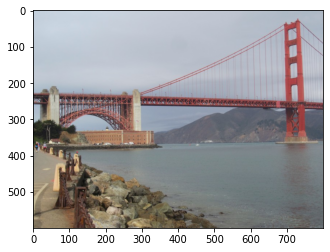

In [18]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    # Load the image
    img = Image.open(img_path)
    
    # Display the image
    plt.imshow(img)
    
    print("Is this a picture of one of the following: {}, {}, {}?".format(predicted_landmarks[0], predicted_landmarks[1], predicted_landmarks[2]))


# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
The output is about what I expected. With a 73% accuracy attained during training I figured the classifier would always have the correct answer within the top few predictions. The pictures I found online weren't the most challenging so I'm not too surprised that 4/5 have the correct class as the first choice.

Points for improvement:
1. Better data preprocessing and augmentation.If the data could be cleaned to remove any irrelevant photos that don't actually contain major landmarks then accuracy may be higher. Artificially brightening, darkening, and adding noise to the images would likely make the network more robust.

2. Trying different network architectures. Other popular architectures like ResNet might perform better on the task.

3. Tweaking training hyperparameters. Decreasing the learning rate, increasing momentum, and allowing the network to train for more epochs may help the network attain a better accuracy. 

In [19]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
import glob

# Grab and display the names of the image files
file_paths = glob.glob('other_images/*')


other_images\atomium.jpg
Is this a picture of one of the following: Atomium, Central Park, Vienna City Hall?


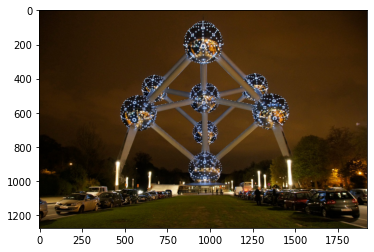

In [20]:
# This probably would have looked much nicer in a for loop but that would require the suggest_locations function to take in
# a list of image paths instead and then create subplots

print(file_paths[0])
suggest_locations(file_paths[0])

other_images\delicate_arch.jpg
Is this a picture of one of the following: Delicate Arch, Dead Sea, Grand Canyon?


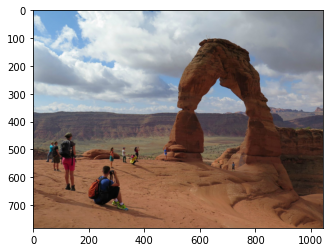

In [21]:
print(file_paths[1])
suggest_locations(file_paths[1])

other_images\Ljubljana_Castle.jpg
Is this a picture of one of the following: Ljubljana Castle, Edinburgh Castle, Whitby Abbey?


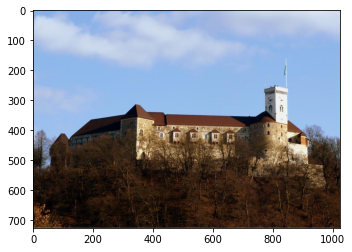

In [22]:
print(file_paths[2])
suggest_locations(file_paths[2])

other_images\prague_astronomical_clock.jpg
Is this a picture of one of the following: Prague Astronomical Clock, Edinburgh Castle, Gateway of India?


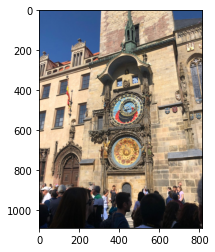

In [23]:
print(file_paths[3])
suggest_locations(file_paths[3])

other_images\Wroclaw_Dwarfs.jpg
Is this a picture of one of the following: Wroclaws Dwarves, Great Wall of China, Edinburgh Castle?


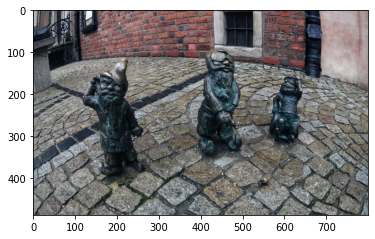

In [24]:
print(file_paths[4])
suggest_locations(file_paths[4])